In [ ]:
#default_exp peakmaps 

# Element distribution maps   

> Slicing the cube  

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# hide 
import os 
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.exposure as ske

from maxrf4u import DataStack

In [ ]:
#hide 
ds = DataStack('RP-T-1898-A-3689.datastack') 
extent = ds.read('imvis_extent')
imvis = ds.read('imvis_reg_highres')

x_keVs = ds.read('maxrf_energies') 
y_max = ds.read('maxrf_maxspectrum')
y_sum = ds.read('maxrf_sumspectrum') 

hotmax_pixels = ds.read('hotmax_pixels')
hotmax_spectra = ds.read('hotmax_spectra')
hotmax_baselines = ds.read('hotmax_baselines')

peak_idxs = hotmax_pixels[:,2]

In order to ultimately create the much appreciated element distribution maps, we need to slice the spectral image cube at all peak locations. This can be done using the function `get_cube_slices()`. This function computes Gaussian peak shapes and corresponding slice indexes for each hotmax pixel in the spectral image cube. The result can be inspected with `plot_cube_slices()` function.  

In [ ]:
from maxrf4u import get_cube_slices, plot_cube_slices, get_peakmaps

<IPython.core.display.Javascript object>


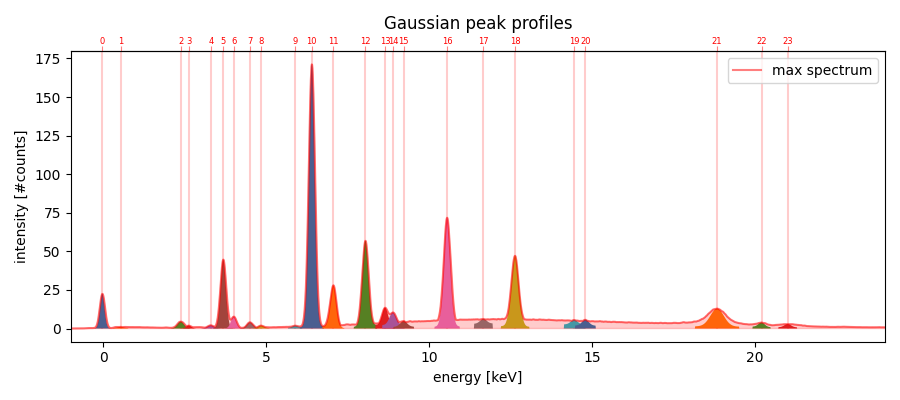

In [ ]:
slices, y_gauss_list = get_cube_slices('RP-T-1898-A-3689.datastack')

ax = plot_cube_slices('RP-T-1898-A-3689.datastack');
ax.set_title('Gaussian peak profiles')
plt.tight_layout()

If life were simple we could now integrate the intensities for a given peak slice to get the corresponding element map, and be done with our work! This is for example the case for our well-known iron $K_{\alpha}$ peak located at 6.40 keV colored blue in the plot above. Let's check the precise limits of energy band that we want to integrate.  

In [ ]:
#collapse-hide 
ds = DataStack('RP-T-1898-A-3689.datastack')
x_keVs = ds.read('maxrf_energies') 

si, sj, sk = slices[10] # These are the Fe_Ka slice indices (left, mid, right) index  

print(f'The Fe_Ka peak located at {x_keVs[sj]:.02f} keV ranges from {x_keVs[si]:.02f} keV to {x_keVs[sk]:.02f} keV.')

The Fe_Ka peak located at 6.40 keV ranges from 6.04 keV to 6.76 keV.


Integration into an element map is simply reading the peak slice from the data cube, summing along the spectral axis and plotting the result.   

<IPython.core.display.Javascript object>


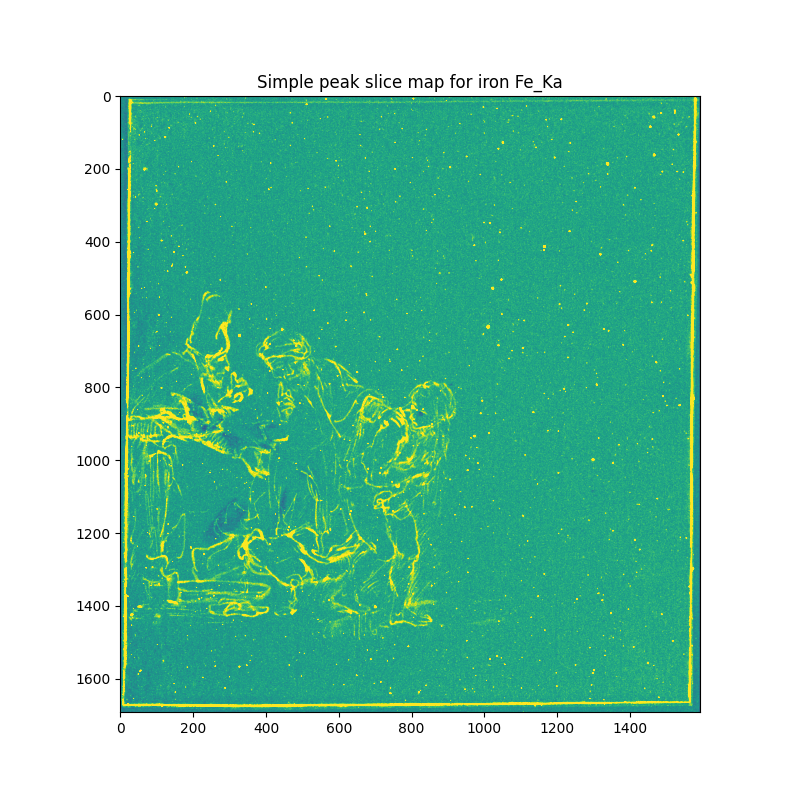

In [ ]:
#collapse-hide  
# read Fe_Ka slice 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)
FeKa_slice = cube[:,:,si:sk+1].compute() # takes a few seconds... 
# integrate
FeKa_map = FeKa_slice.sum(axis=2)
# and plot...

fig, ax = plt.subplots(figsize=[8, 8])
ax.imshow(FeKa_map, vmax=75); # need to clip intensity due iron speckles  
ax.set_title('Simple peak slice map for iron Fe_Ka');

For now we just ignore errors due  overlapping bands and take a preliminary look at all peak maps by simply integrating all peak slices use the `get_peakmaps()` function. 

In [ ]:
peak_maps, keV_maps = get_peakmaps('RP-T-1898-A-3689.datastack', slices, algorithm='simple')

Please wait two minutes while computing peak maps... 
Ready computing 24 peak maps.


Although it is clear that these peak maps are not perfect yet, let's take a look. Starting point for the analysis of the maps is the summary of the peak pattern puzzle from the previous section.   

<IPython.core.display.Javascript object>


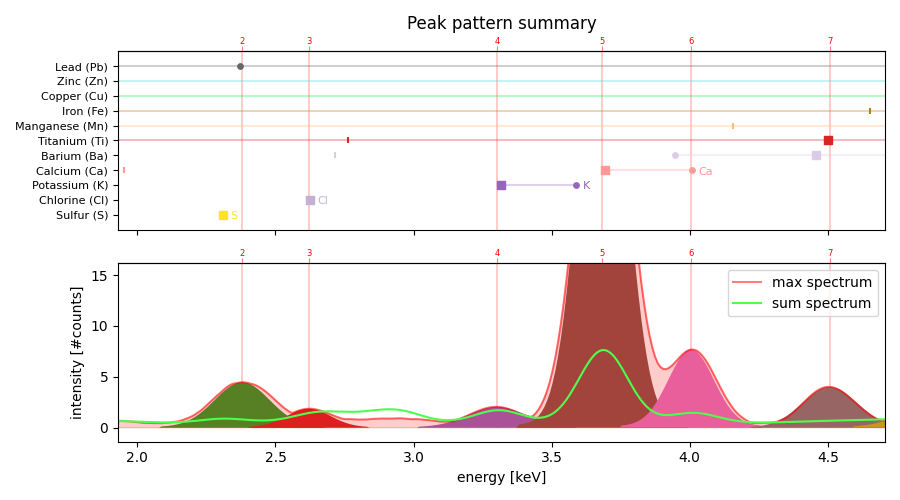

In [ ]:
#collapse-hide 
from maxrf4u import plot_patterns, get_patterns 

ptrn_list = get_patterns(['S', 'Ca', 'K', 'Cl', 'Fe', 'Mn', 'Cu', 'Zn', 'Pb', 'Ti', 'Ba'])

fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[9, 5])

plot_patterns(ptrn_list, ax=ax)
_add_hotlines_ticklabels('RP-T-1898-A-3689.datastack', ax, clip_vline=False) 

plot_cube_slices('RP-T-1898-A-3689.datastack', ax=ax1); 


ax1.plot(x_keVs, 8*y_sum, color=[0.3, 1, 0.3], label='sum spectrum')
ax1.legend();

ax.set_title('Peak pattern summary')
plt.tight_layout()

Here is the overview of all 24 peak maps. 

<IPython.core.display.Javascript object>


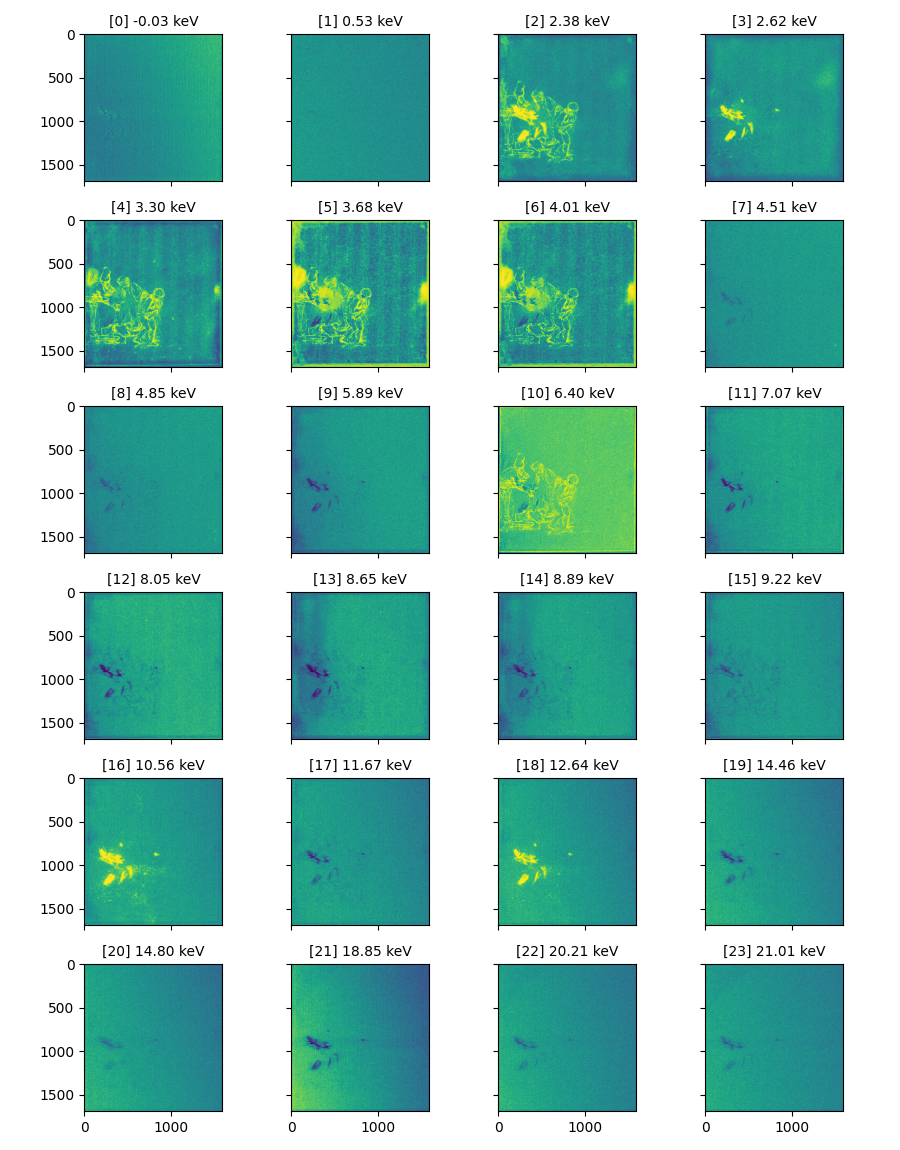

In [ ]:
#collapse-hide 
peak_maps_histeq = [ske.equalize_hist(pm) for pm in peak_maps]

titles = [f'[{i}] {x_keVs[peak_idx]:.02f} keV' for i, peak_idx in enumerate(peak_idxs)]

multi_plot(*peak_maps_histeq, titles=titles); 

## Baseline estimation 

Unfortunately for most other peaks then iron  XRF life is not so simple. There are a two complications that we need to take into account.  Especially for MA-XRF scans of drawings on paper we need to deal with many spectra for locations in contain only light elements. As a consequence a significant portion of their signal is due to inelastic (Compton) and elastic scattering by hydrogen atoms in the paper. We need to correct for this Compton ridge baseline when integrating these peaks. Our second problem is the occurrence of overlapping peaks. Let's first solve the baseline estimation problem... 

The technical challenge here is that the baseline which is due to to scattering of the paper substrate will vary according to the local paper thickness, but also due to the local presence of heavier elements such as lead. A layer of lead atoms on top of a paper absorbs the incoming x-rays that therefore will not reach the paper and hence not be scattered to the detector. Spectra that contain lead peaks typically have a lower scattering baseline. 

This behavior is exemplified if we compare two different hotmax spectra 

<IPython.core.display.Javascript object>


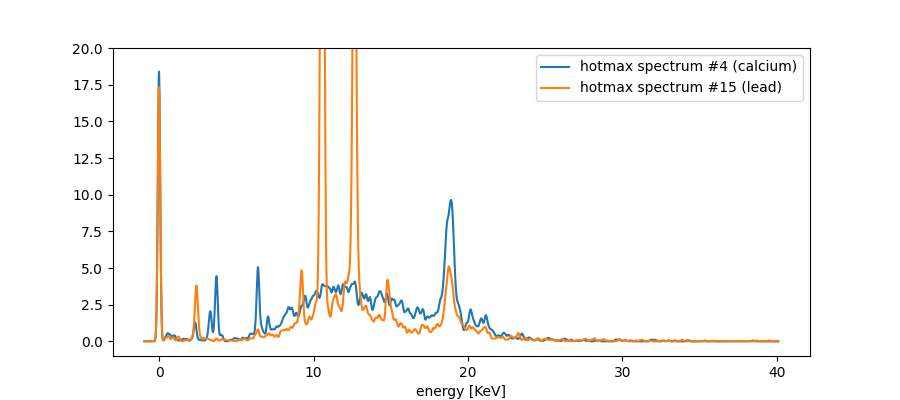

In [ ]:
#hide_input 
hotmax_spectra = ds.read('hotmax_spectra')
y_sum = ds.read('maxrf_sumspectrum')

calcium_spectrum = hotmax_spectra[4]
lead_spectrum = hotmax_spectra[15]

fig, ax = plt.subplots(figsize=[9, 4])

ax.plot(x_keVs, calcium_spectrum, label='hotmax spectrum #4 (calcium)')
ax.plot(x_keVs, lead_spectrum, label='hotmax spectrum #15 (lead)')

ax.set_ylim([-1, 20])
ax.set_xlabel('energy [KeV]')
ax.legend();

The slowly varying ridge with Poisson noise and element specific emission peaks can clearly be seen in both spectra. 

## Functions 

In [ ]:
#export 

import numpy as np 
import scipy.interpolate as sip
import scipy.signal as ssg 
from maxrf4u import DataStack, HotmaxAtlas 
from dask.diagnostics import ProgressBar 
import matplotlib.pyplot as plt 
import skimage.exposure as ske 
import skimage.morphology as skm 
from scipy.ndimage import gaussian_filter1d 


def get_cube_slices(datastack_file, tail_clip=0.05): 
    '''Computes fitted and clipped Gaussian peak shapes for all hotmax pixels. 
    
    Returns: `peak_slices`, `y_gauss_list` '''
    
    # read stuff from datastack 
    ds = DataStack(datastack_file) 

    x_keVs = ds.read('maxrf_energies') 
    hotmax_pixels = ds.read('hotmax_pixels')
    hotmax_spectra = ds.read('hotmax_spectra')
    hotmax_baselines = ds.read('hotmax_baselines')

    peak_idxs = hotmax_pixels[:,2]

    # get slices by fitting gaussian to corresponding hotmax spectrum and baseline 
    y_gauss_list = []
    peak_slices = []

    # step 1: create tail clipped gaussians 
    for i, peak_idx in enumerate(peak_idxs):  

        y_hot = hotmax_spectra[i]
        baseline = hotmax_baselines[i]
        y_gauss_fit, baseline = _fit_gaussian(x_keVs, y_hot, peak_idx, baseline=baseline) 

        y_gauss_flat =  y_gauss_fit - baseline 

        # clip peak tails below tail_clip level  
        mask = np.ones_like(y_gauss_flat) 
        is_below_clip = y_gauss_flat < tail_clip 
        mask[is_below_clip] = 0 
        y_gauss_fit_clipped = y_gauss_fit * mask 
        
        y_gauss_list.append(y_gauss_fit_clipped) 
        
        # peak slices
        peak_domain_idxs = np.argwhere(y_gauss_fit_clipped) 
        i = peak_domain_idxs.min()
        j = peak_idx 
        k = peak_domain_idxs.max() 
        
        peak_slices.append([i,j,k])
        
    return peak_slices, y_gauss_list 



def _gaussian(x, x0, sigma): 
    '''Normal distribution around `x0` with standard deviation `sigma`.'''
    
    y = np.exp(-0.5 * ((x - x0) / sigma)**2)
    
    return y 


def _fit_gaussian(x, y, peak_idx, rel_height=0.2, baseline=None): 
    '''Fit single gaussian distribution at `rel_height`. 
    
    Returns: `y_gauss`, `baseline`
    '''
    
    # just a single peak 
    [widths], [width_height], [left_ips], [right_ips] = ssg.peak_widths(y, [peak_idx], rel_height=rel_height)
    
    # create energy interpolation 
    keV_ipol = sip.interp1d(np.arange(len(x)), x)
     
    left_x = keV_ipol(left_ips)
    right_x = keV_ipol(right_ips)
    
    # pick smallest half width at rel_height 
    dx_left = left_x - x[peak_idx] 
    dx_right = right_x - x[peak_idx] 
    
    dx = sorted([dx_left, dx_right])[0] 
    
    # create baseline  
    if baseline is None:  
        baseline = np.zeros_like(y) 
        
    y_norm = (width_height - baseline[peak_idx]) / (y[peak_idx] - baseline[peak_idx]) 
    
    # assert that y_norm is positive 
    assert y_norm > 0, f"Can't fit Gaussian for peak below baseline for peak index {peak_idx}."   
        
    # calculate corresponding sigma 
    sigma = np.sqrt(-dx**2 / (2 * np.log(y_norm)))
    
    # calculate gaussian with baseline 
    y_gauss = (y[peak_idx] - baseline[peak_idx]) * _gaussian(x, x[peak_idx], sigma) + baseline
    
    return y_gauss, baseline 
       

# Plotting 

def plot_cube_slices(datastack_file, ax=None, tail_clip=0.05, xlim=[-1, 24]): 
    
    # read data 
    ds = DataStack(datastack_file) 
    x_keVs = ds.read('maxrf_energies')
    y_max = ds.read('maxrf_maxspectrum') 
    
    if ax is None: 
        fig, ax = plt.subplots(figsize=[9, 4]) 
        
    y_gauss_list = get_cube_slices(datastack_file, tail_clip=tail_clip)[1] 
    
    for y_gauss in y_gauss_list: 
        
        ax.fill_between(x_keVs, y_gauss) 
        
    ax.plot(x_keVs, y_max, color='r', alpha=0.5, label='max spectrum')
    ax.fill_between(x_keVs, y_max, color='r', alpha=0.2)
        
    _add_hotlines_ticklabels(datastack_file, ax)
    
    ax.set_xlim(xlim)
    
    ax.set_xlabel('energy [keV]')
    ax.set_ylabel('intensity [#counts]') 
    
    ax.legend()
    
    plt.tight_layout()
    
    return ax
        
        

def _add_hotlines_ticklabels(datastack_file, ax, clip_vline=True): 
    '''Utility function. Adds hotlines and tick labels to plot `ax`. 
    
    '''
    # read hotlines data 
    ds = DataStack(datastack_file) 
    x_keVs = ds.read('maxrf_energies')
    peak_idxs = ds.read('hotmax_pixels')[:, 2] 
    
    secax = ax.secondary_xaxis('top')

    secax.set_xticks(x_keVs[peak_idxs]) 
    
    ymin, ymax = ax.get_ylim() 
    
    # clip vlines at y=0
    if clip_vline: 
        ax.vlines(x_keVs[peak_idxs], 0, 1.2*ymax, color='r', alpha=0.2, zorder=9-30)
        ax.set_ylim(ymin, ymax)
    
    # do not clip vlines 
    else: 
        for x in x_keVs[peak_idxs]:
            ax.axvline(x, color='r', alpha=0.2, zorder=9-30)

    secax.set_xticks(x_keVs[peak_idxs])
    secax.set_xticklabels(range(len(peak_idxs)), fontsize=6, color='r') 
    secax.tick_params(color=[1, 0.5, 0.5], pad=0) 
    
    return ax 


# peak maps 

def get_peakmaps(datastack_file, slices, norm=True, verbose=False): 
    '''Integrate peak `slices`  into peak maps and keV maps. 
    
    Returns: peak_maps, keV_maps'''
    
    ds = DataStack(datastack_file)
    x_keVs = ds.read('maxrf_energies')
    cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)
    
    peak_maps = []
    keV_maps = []
    
    # skipping baseline correction for now 
    # can not be based on super slices 
    
    n_channels = len(x_keVs) 
    
    print('Please wait two minutes while computing peak maps... ')

    for i, [si, sj, sk] in enumerate(slices): 

        peak_slice = cube[:,:,si:sk+1].compute() 

        # average over slice layers 
        print(f'Computing peak_map {i}/{len(slices)-1}...', end='\r')
        d = peak_slice.shape[-1]
        peak_map = np.sum(peak_slice, axis=2) / d 

        if norm:  
            peak_map = peak_map / peak_map.max()

        keV_idx_map = si + np.argmax(peak_slice, axis=2)
        keV_map = x_keVs[keV_idx_map]

        peak_maps.append(peak_map) 
        keV_maps.append(keV_map)
        
    print(f'Ready computing {len(slices)} peak maps.')
    
    return peak_maps, keV_maps  



def multi_plot(*images, hot_pixel=None, titles=None, roi_list=None, axis_off=False, 
               sharex=True, sharey=True, vmin=None, vmax=None, cmap='viridis', 
               fontsize='medium', zoom_xyc=None, zoom_half_wh=[100, 100]): 
    '''Inspect multiple images simultaneously... 
    
    Fold along multiple rows if n > 4'''
    
    nrows_max = 4 
    n_img = len(images)
    
    nrows = (n_img // nrows_max) # completely filled rows 
    rest = n_img % nrows_max 
    if rest != 0:
        nrows = nrows + 1
    
    if n_img <= nrows_max: 
        ncols = n_img
    else: 
        ncols = nrows_max
        
    figsize = [9, 5 + 1.3 * (nrows -1)]
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False, sharex=sharex, sharey=sharey)
    
    for i, img in enumerate(images): 
    
        axs.flatten()[i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        
        if hot_pixel is not None: 
            hot_yi, hot_xi, hot_zi = hot_pixel 
            axs.flatten()[i].scatter(hot_xi, hot_yi, color='r')
        
        if zoom_xyc is not None:
            xc, yc = zoom_xyc
            w_ha, h_ha = zoom_half_wh 

            axs.flatten()[i].set_xlim(xc - w_ha, xc + w_ha)
            axs.flatten()[i].set_ylim(yc + h_ha, yc - h_ha)
        
        if roi_list is not None: 
            add_roi_patches(axs.flatten()[i], roi_list)
            
    if titles is not None:
        for i, t in enumerate(titles): 
            axs.flatten()[i].set_title(t, fontsize=fontsize)
    
    # seems to have no effect: 
    for i in range(n_img, nrows * ncols): 
        axs.flatten()[i].axis('off')
    # therefore trying this: 
    if axis_off: 
        axs_flat = axs.flatten()
        for ax in axs_flat: 
            ax.set_axis_off()
        
    fig.subplots_adjust(hspace=0.1, wspace=0.1)    
            
    plt.tight_layout()
    
    return fig, axs 


# better baseline estimation ? 

def get_continuum(x, y_sum, slices, left_peak_idx=18, plot_this=False):
    '''Create smoothed, gap normalized background from sum spectrum `y_sum`.
    
    Just a quick hack to remove little peaks. 
    
    Returns: gap_slice, y_cont
    '''
    
    # This is still rather hacky 
    # probably does not work for other dataset 
    
    # smooth a bit 
    y_filtered = gaussian_filter1d(y_sum, 50) 

    # replace middle part 
    y_cont = y_sum.copy() 
    m = 600
    n = 1750 
    y_cont[m:n] = y_filtered[m:n]
    
    # make exponential left tail
    y_cont[0:m] = y_cont[m] * np.linspace(0, 1, m)**4

    # smooth again to get rid of tiny discontinuities 
    y_cont = gaussian_filter1d(y_cont, 10)
    
    # peak free region for continuum normalization  
    # not sure how to automate this choice 

    # 18 - 19 is near continuum top and fairly large gap region 
    #left_peak_idx = 18 
    right_peak_idx = left_peak_idx + 1
    gap_i = slices[left_peak_idx][2] + 1
    gap_j = slices[right_peak_idx][0] -1  
    gap_slice = [gap_i, gap_j]
    
    gap_average = get_gap_average(y_cont, gap_slice)
    
    # normalize at gap band 
    y_cont = y_cont / gap_average
    
    # experimental code so plot to inspect 
    if plot_this: 
        fig, ax = plt.subplots()
        ax.plot(x, y_cont)
        gap_mask = np.zeros_like(y_cont)
        gap_mask[gap_i:gap_j+1] = 1
        ax.fill_between(x_keVs, y_cont, where=gap_mask)
    
    return gap_slice, y_cont  


def get_gap_average(y, gap_slice): 
    
    # need to make multi dimensional 
    gap_i, gap_j = gap_slice 
    gap_width = gap_j - gap_i 
    gap_average = y[gap_i:gap_j+1].sum() / gap_width 
    
    return gap_average 
    

<IPython.core.display.Javascript object>


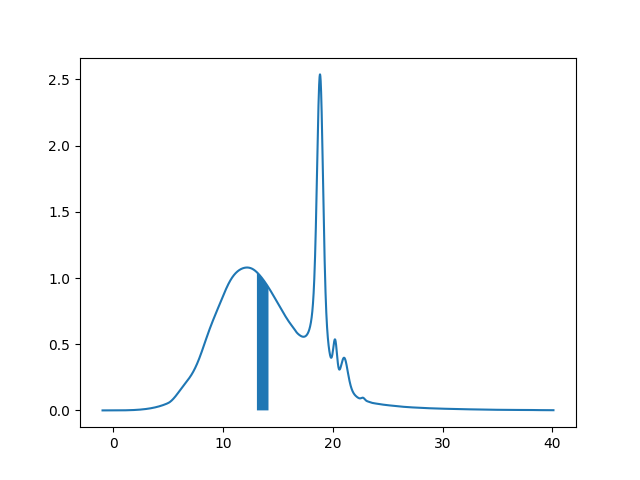

In [ ]:
gap_slice, y_cont = get_continuum(x_keVs, y_sum, slices, plot_this=True)

Now I need to inspect how well this continuum baseline fits different spectra. 

In [ ]:
hma = HotmaxAtlas('RP-T-1898-A-3689.datastack')

<IPython.core.display.Javascript object>


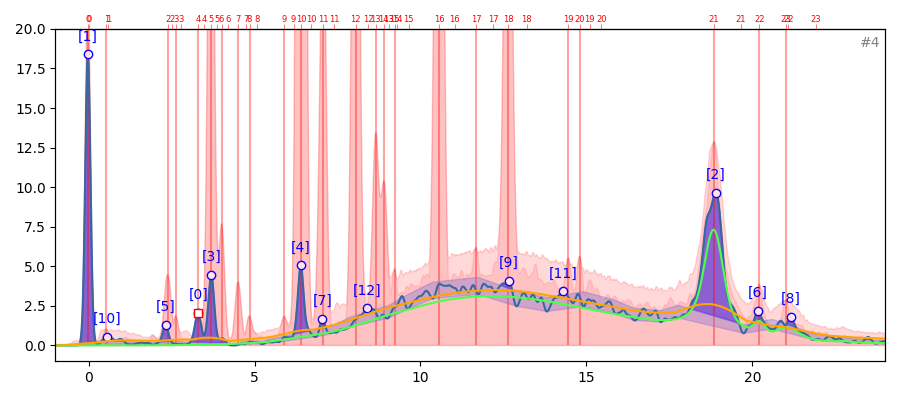

In [ ]:
n = 4

y_hot = hotmax_spectra[n] 
y_snip = bsl.smooth.snip(y_hot, 50, )[0]

gap_slice, y_cont = get_continuum(x_keVs, y_sum, slices)

gap_average = get_gap_average(y_hot, gap_slice)

y_cont_baseline = y_cont * gap_average 

fig, ax = plt.subplots(figsize=[9, 4])

hma.plot_spectrum(n, ax)
ax.plot(x_keVs, y_cont_baseline, color=[0.3, 1, 0.3])
_add_hotlines_ticklabels('RP-T-1898-A-3689.datastack', ax)
ax.set_xlim([-1, 24])
ax.set_ylim([-1, 20]);
#ax.plot(x_keVs, np.log(20*mu_Pb), color='k')
ax.plot(x_keVs, 0.6*y_maxsnip, color='orange')

In [ ]:
import xraydb 

In [ ]:
x_eVs = 1000 * x_keVs
mu_Pb = xraydb.mu_elam('Pb', x_eVs)

In [ ]:
import pybaselines as bsl

In [ ]:
y_maxspectrum

array([0.00239436, 0.00272245, 0.00339439, ..., 0.30186892, 0.31268886,
       0.31824136], dtype=float32)

<IPython.core.display.Javascript object>


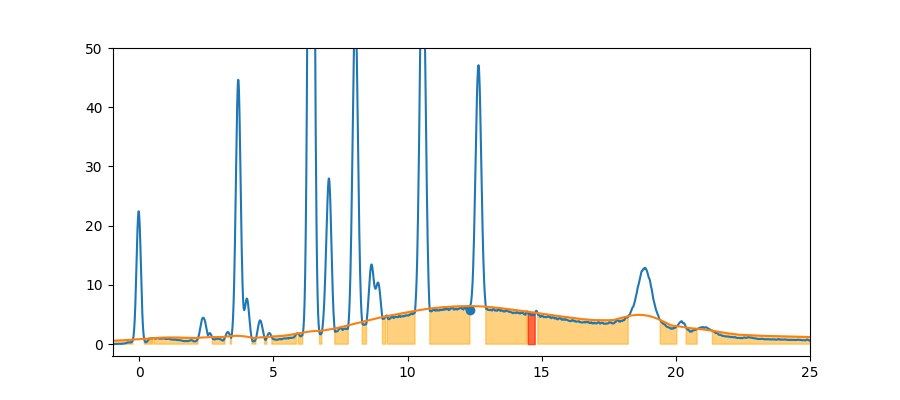

In [ ]:
y_maxsnip = bsl.smooth.snip(y_maxspectrum, 30, decreasing=True)[0]

y_maxsnip_noiseline = y_maxsnip + 0.1*y_maxsnip.max()

is_gap = y_maxsnip_noiseline > y_maxspectrum

fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(x_keVs, y_maxspectrum)
ax.plot(x_keVs, y_maxsnip_noiseline)

ax.fill_between(x_keVs, y_maxsnip_noiseline, where=is_gap, color='orange', alpha=0.5)
ax.fill_between(x_keVs, y_maxsnip_noiseline, where=(labeled==19), color='r', alpha=0.5)
ax.set_xlim([-1, 25])
ax.set_ylim([-2, 50]);
ax.scatter(x_keVs[hill_top_idx], y_maxsnip[hill_top_idx])

Need to inspect the width of each gap band to select best one. Or instead test dask boolean indexing. 

In [ ]:
is_test = np.zeros_like(x_keVs).astype(bool)

In [ ]:
hill_top_idx = np.argmax(y_maxsnip)

In [ ]:
is_test[1000:1100] = True

In [ ]:
test_slice = cube[:,:,is_test]

In [ ]:
test_slice

dask.array<getitem, shape=(1692, 1592, 100), dtype=float32, chunksize=(282, 398, 76), chunktype=numpy.ndarray>

In [ ]:
import skimage.morphology as skm

In [ ]:
sizes[19-1]

27

In [ ]:
labeled = skm.label(is_gap)

In [ ]:
sizes = []
for l in range(1, labeled.max()): 
    
    d = np.sum(labeled == l)
    sizes.append(d)

In [ ]:
sizes

[75,
 21,
 3,
 5,
 164,
 48,
 5,
 16,
 10,
 92,
 18,
 10,
 51,
 17,
 13,
 104,
 150,
 153,
 27,
 337,
 63,
 42]

<IPython.core.display.Javascript object>


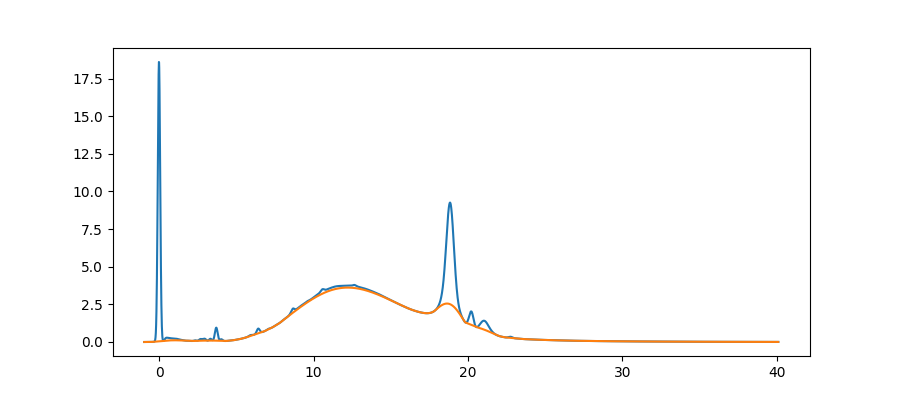

In [ ]:
y_sumsnip = bsl.smooth.snip(y_sum, 30, decreasing=True)[0]

fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(x_keVs, y_sum)
ax.plot(x_keVs, y_sumsnip)

#hide 

## Issues + features 

* (Implemented) Add escape peak to pattern 
* (Failed) Optimize peak map integration with dask delayed 
* More clear peak slices to show overlaps 
* Correct overlapping peaks (need per spectrum baseline estimation) 
* Per spectrum baseline estimation (and implement in get_peakmaps() 
* SVG output for multi_plot 
* hotmax pixels in multi_plot 


In [ ]:
slices, y_gauss_list = get_cube_slices('RP-T-1898-A-3689.datastack')

In [ ]:
import matplotlib.cm as cm 

In [ ]:
y_continuum = smooth_compton(y_sum)

In [ ]:
#def get_continuum_gap_mask 
# peak free region for continuum normalization  
# not sure how to automate this choice 

# 18 - 19 is near continuum top and fairly large region 
left_peak_idx = 18 
right_peak_idx = left_peak_idx + 1
gap_band_i = slices[left_peak_idx][2] + 1
gap_band_j = slices[right_peak_idx][0] -1  

continuum_gap_mask = np.zeros_like(x)
continuum_gap_mask[gap_band_i:gap_band_j+1] = 1

print(f'Gap  region width: {gap_band_j - gap_band_i}')

Gap  region width: 105


In [ ]:
y_

<IPython.core.display.Javascript object>


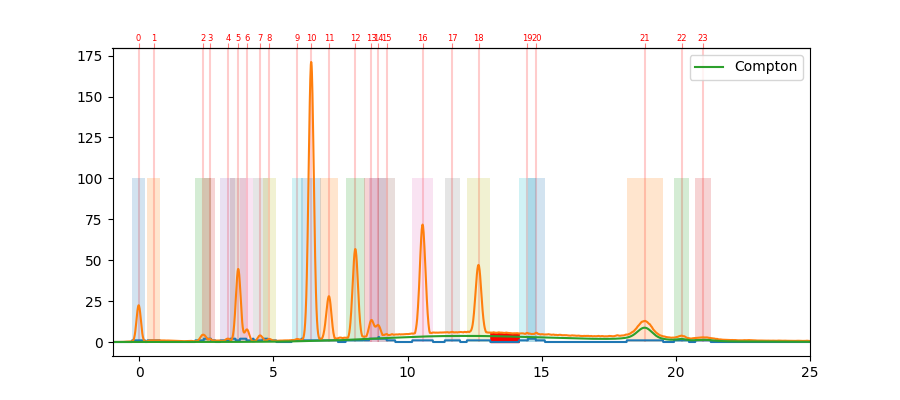

In [ ]:
x = x_keVs 
y_maxspectrum = ds.read('maxrf_maxspectrum')
#def plot_cube_slices(slices, x, y): 

mask_list = []

for [si, sj, sk] in slices: 
    
    mask = np.zeros_like(x) 
    
    mask[si:sk+1] = 1
    
    mask_list.append(mask)
    
sum_mask = np.array(mask_list).sum(axis=0)
    
fig, ax = plt.subplots(figsize=[9, 4])

for i, mask in enumerate(mask_list): 
    
    ax.fill_between(x, 100*mask, where=mask, alpha=0.2)
    sj = slices[i][1]
    #ax.axvline(x[sj], color='r')
    
ax.plot(x, sum_mask)
ax.plot(x, y_maxspectrum) 
ax.plot(x, y_compton, label='Compton')
ax.legend()
_add_hotlines_ticklabels('RP-T-1898-A-3689.datastack', ax)

ax.fill_between(x, y_maxspectrum, where=continuum_gap_mask, color='r')

ax.set_xlim([-1, 25]);

In this case, the best 

<IPython.core.display.Javascript object>


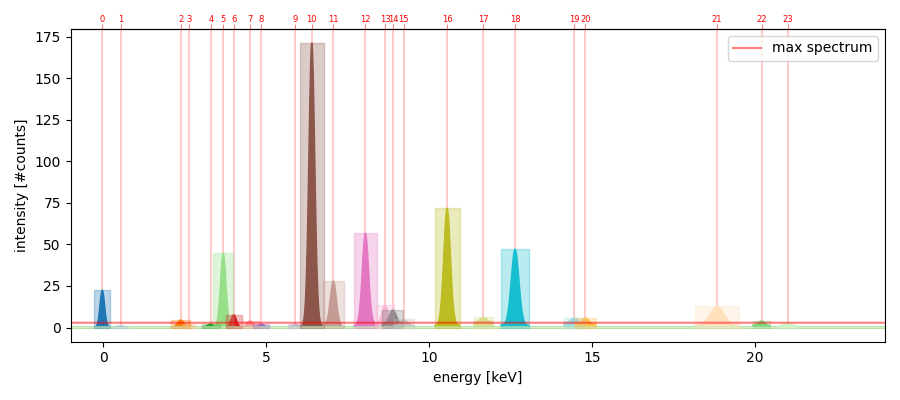

In [ ]:
datastack_file = 'RP-T-1898-A-3689.datastack'
tail_clip = 0.05 
xlim = [-1, 24]

#def plot_cube_slices(datastack_file, ax=None, tail_clip=0.05, xlim=[-1, 24]): 
    
# read data 
ds = DataStack(datastack_file) 
x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum') 

slices, y_gauss_list = get_cube_slices(datastack_file, tail_clip=tail_clip) 

n_slices = len(slices)

fig, ax = plt.subplots(figsize=[9, 4])

# tab20x2 color map 
# (there should be an easier way to cycle colors)
tab20 = cm.tab20(np.arange(20))[:,0:3]
tab20_r = cm.tab20_r(np.arange(20))[:,0:3]
tab20x2 = np.r_[tab20, tab20[2:]**0.4]
colors = tab20x2[0:n_slices]

# color gaussian peaks  

for i, y_gauss in enumerate(y_gauss_list): 

    ax.fill_between(x_keVs, y_gauss, color=colors[i]) 

# color corresponding slice  
for i, [si, sj, sk] in enumerate(slices): 
    
    is_slice = np.zeros_like(x_keVs)
    is_slice[si:sk+1] = 1  
    
    y_max = y_gauss_list[i].max() * np.ones_like(x_keVs) 
    
    ax.fill_between(x_keVs, y_max, where=is_slice, color=colors[i], alpha=0.3)

ax.plot(x_keVs, y_max, color='r', alpha=0.5, label='max spectrum')
#ax.fill_between(x_keVs, y_max, color='r', alpha=0.2)

_add_hotlines_ticklabels(datastack_file, ax)

ax.set_xlim(xlim)

ax.set_xlabel('energy [keV]')
ax.set_ylabel('intensity [#counts]') 

ax.legend()

plt.tight_layout()
    
# return ax

<IPython.core.display.Javascript object>


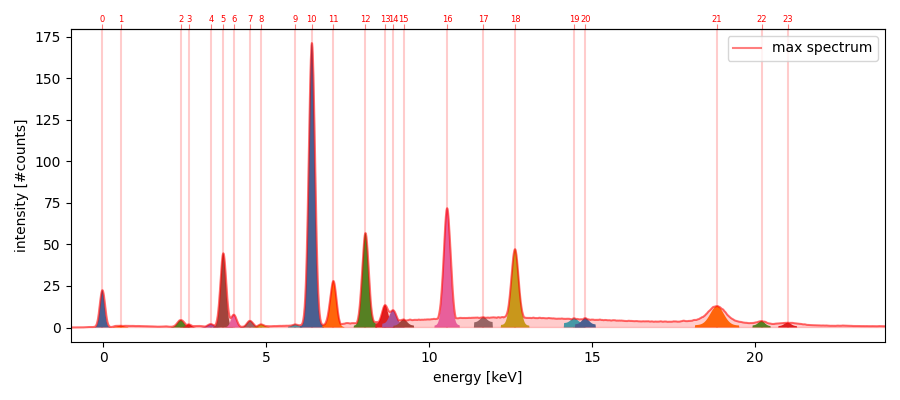

<AxesSubplot:xlabel='energy [keV]', ylabel='intensity [#counts]'>

In [ ]:
plot_cube_slices('RP-T-1898-A-3689.datastack')

In [ ]:
# Plotting 

def plot_cube_slices(datastack_file, ax=None, tail_clip=0.05, xlim=[-1, 24]): 
    
    # read data 
    ds = DataStack(datastack_file) 
    x_keVs = ds.read('maxrf_energies')
    y_max = ds.read('maxrf_maxspectrum') 
    
    if ax is None: 
        fig, ax = plt.subplots(figsize=[9, 4]) 
        
    y_gauss_list = get_cube_slices(datastack_file, tail_clip=tail_clip)[1] 
    
    for y_gauss in y_gauss_list: 
        
        ax.fill_between(x_keVs, y_gauss) 
        
    ax.plot(x_keVs, y_max, color='r', alpha=0.5, label='max spectrum')
    ax.fill_between(x_keVs, y_max, color='r', alpha=0.2)
        
    _add_hotlines_ticklabels(datastack_file, ax)
    
    ax.set_xlim(xlim)
    
    ax.set_xlabel('energy [keV]')
    ax.set_ylabel('intensity [#counts]') 
    
    ax.legend()
    
    plt.tight_layout()
    
    return ax

# Explorations 

## Zinc in the paper background 

While trying to extract a smooth scattering baseline from the sum spectrum, my eye was drawn to a peak at the Zinc $K_{\alpha}$ energy. Because we see no copper, it seems that there is a low concentration of zinc present at a large surface in the drawing. I do not understand the source for that? Is is a modern conservation material? In order to find out I need a good peak map. Let's see if we can make one without yet having implemented the baseline estimation and peak overlap corrections... 

<IPython.core.display.Javascript object>


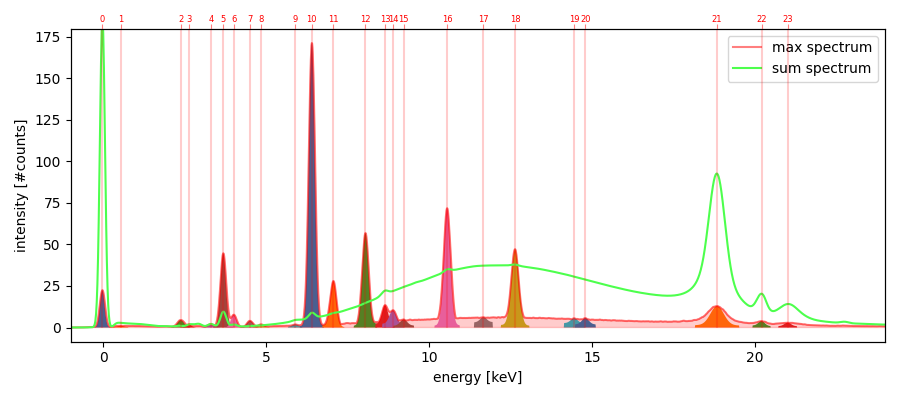

In [ ]:
fig, ax, twax = plot_cube_slices('RP-T-1898-A-3689.datastack')
ax.plot(x_keVs, 10 * y_sum, color=[0.3, 1, 0.3], label='sum spectrum')
ax.legend();

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')
x_keVs = ds.read('maxrf_energies') 

si, sj, sk = slices[13] # Zn_Ka slice (left, mid, right) index 

# read Zn_Ka slice 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)
with ProgressBar(): 
    ZnKa_slice = cube[:,:,si:sk+1].compute() # takes a few seconds... 
# integrate
ZnKa_map = ZnKa_slice.sum(axis=2)
# and plot

[########################################] | 100% Completed |  3.3s


<IPython.core.display.Javascript object>


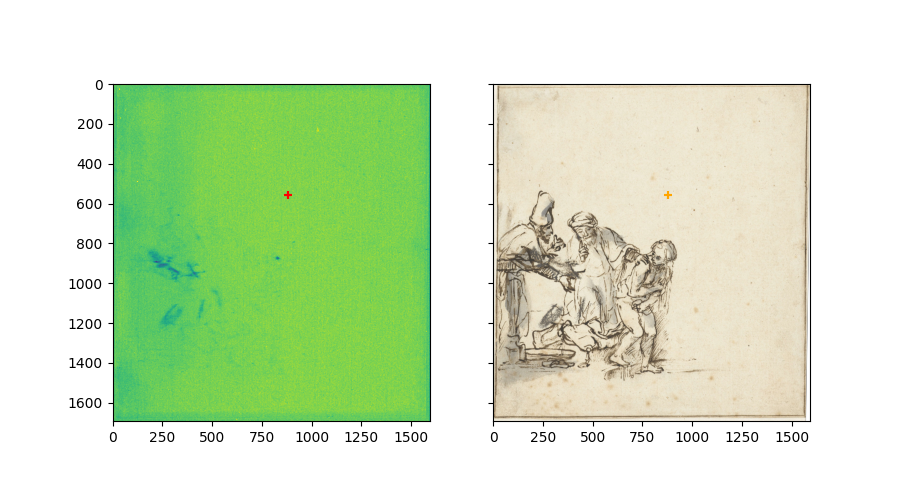

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[9, 5])
ax.imshow(ZnKa_map, vmax=150); # need to clip?  
ax1.imshow(imvis, extent=extent)

x, y = 880, 555 
x2, y2 = 881, 559

ax.scatter(x, y, marker='+', color='r')
ax1.scatter(x, y, marker='+', color='orange')

ax.scatter(x2, y2, marker='+', color='r')
ax1.scatter(x2, y2, marker='+', color='orange')

In [ ]:
spectrum_xy = cube[x, y].compute()
spectrum_xy2 = cube[x2, y2].compute()

In [ ]:
i, j, k = slices[13] # Zn 
Zn_band = np.zeros_like(spectrum_xy)
Zn_band[i:k+1] = 1

<IPython.core.display.Javascript object>


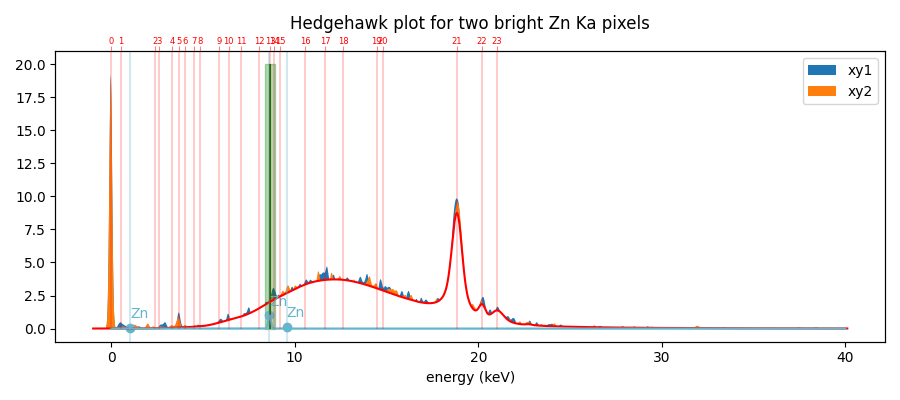

In [ ]:
fig, ax = plt.subplots(figsize=[9, 4])
ax.fill_between(x_keVs, spectrum_xy, y_compton, where=(spectrum_xy>y_compton), label='xy1')
ax.fill_between(x_keVs, spectrum_xy2, y_compton, where=(spectrum_xy2>y_compton), label='xy2')


#ax.fill_between(x_keVs, spectrum_xy - y_compton, y_compton - y_compton, where=(spectrum_xy>y_compton), label='xy1')
ax.plot(x_keVs, y_compton, color='r')
ax.fill_between(x_keVs, 20 * Zn_band, where=(Zn_band>0), color='g', alpha=0.3)
ax.vlines([x_keVs[j]], 0, 20, color='g')
ax.legend()
_add_hotlines_ticklabels('RP-T-1898-A-3689.datastack', ax)
mos.XFluo('Zn', tube_keV=40).plot(ax=ax);
ax.set_title('Hedgehawk plot for two bright Zn Ka pixels')
plt.tight_layout()

In [ ]:
mos.XFluo('Zn', tube_keV=40).plot(ax=ax);

## Compton peak 

How does the gradient from left to right for zinc correlate to the Compton peak? I now wonder if the varying baseline in the cube is simply all related to the absorption of lead?  

In [ ]:
si, sj, sk = slices[21] # Rh_Ka Compton 

# read Compton_Rh_Ka slice 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)
with ProgressBar(): 
    Compton_slice = cube[:,:,si:sk+1].compute() # takes a few seconds... 
# integrate
Compton_map = Compton_slice.sum(axis=2)


[########################################] | 100% Completed |  6.3s


<IPython.core.display.Javascript object>


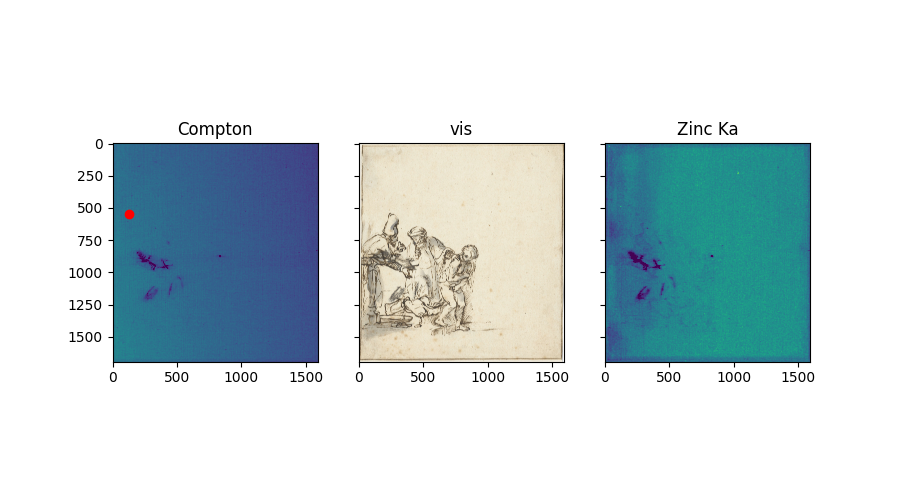

In [ ]:
fig, [ax, ax1, ax2] = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[9, 5])

ax.imshow(Compton_map, vmin=650); # need to clip?  
ax.set_title('Compton')
ax.scatter(*Compton_max[::-1], color='r')

ax1.imshow(imvis, extent=extent)
ax1.set_title('vis')

ax2.imshow(ZnKa_map, vmin=100, vmax=150); # need to clip?  
ax2.set_title('Zinc Ka');

In [ ]:
Compton_max = np.argwhere(Compton_map==Compton_map.max()).flatten()
Compton_max

array([547, 127])

#hide 

## Some notes 

* Peak #5[6]  is an escape peak for Ca_Ka 
* Manganese and chlorine seem like single grains 
* Sulfur is completely hidden by lead 
* Can compute expected Pb peak intensity and subtract 
* Segmentation is a thing 